In [79]:
import numpy as np
import pandas as pd
import time
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from collections import Counter
from matplotlib import pyplot as plt
import pickle


In [72]:
#read in a csv file
data_land = pd.read_csv("land_use_medium.csv")
data_open = pd.read_csv("open_space_medium.csv")
#pull out only the shape column which are all in string format
shape_open = data_open["SHAPE"]
shape_col = data_land["SHAPE"]
#pull out column of attributes you are also using 
usage_data = data_land["LU05_DESC"]

In [73]:
def generate_grid(x, y, cell_num):
    """ Inputs: array with latitude min and latitude max, array with longitude min and longitude max, and number of cells
    Actions: Creates a grid using this data
    Outputs: an array of the x ticks, an array of the y ticks, the x and y widths of a single cell """

    x_min = x[0]
    x_max = x[1]



    y_min = y[0]
    y_max = y[1]

    #Create ticks
    x_s = np.linspace(x_min, x_max, cell_num + 1)
    y_s = np.linspace(y_min, y_max, cell_num + 1)

    #Create grid
    x_coord, y_coord = np.meshgrid(x_s, y_s)

    #length and width of a single cell
    x_shift = np.abs(x_s[1] - x_s[0])
    y_shift = np.abs(y_s[1] - y_s[0])
    return x_coord, y_coord, x_shift, y_shift

In [74]:
def gen_rand_pts(min_lat, min_long, delta_x, delta_y, y_cell, x_cell, rand_num):
    """ Inputs: latitude min, latitude max, longitude min, longitude max, number of x and y cells, number of random points
    Actions: First, it creates random points within the boundaries of a single cell. Then, it translates these random points
    to each cell.
    Outputs: a list of arrays of random points per cell """
    #generate random points of a single cell
    rand_x_grid1 = np.random.uniform(min_lat, min_lat + x_shift, rand_num)
    rand_y_grid1 = np.random.uniform(min_long, min_long + y_shift, rand_num)
    old_grid_pts = np.array(list(zip(rand_x_grid1, rand_y_grid1)))
    plt.scatter(rand_x_grid1, rand_y_grid1)
    plt.show()
    
    list_of_pts = []  
    new_grid_pts = np.copy(old_grid_pts)
    for y_tick in range(y_cell):
        for x_tick in range(x_cell):
            new_grid_pts[:, 0] =  old_grid_pts[:, 0] + delta_x * x_tick #shift horizontally
            list_of_pts.append(np.copy(new_grid_pts))
        new_grid_pts[:, 1] += delta_y #shift vertically
    return list_of_pts

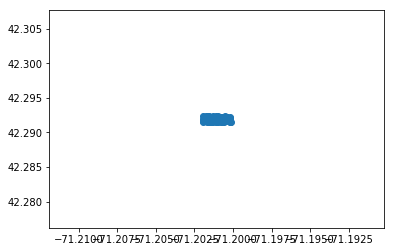

In [75]:
"""Testing the function above"""
x = [ -71.20197, -70.96679]
y = [42.291441, 42.420578]
cell_num = 130
x_cell = 130
y_cell = 130
num_pts = 100
x_coord, y_coord, x_shift, y_shift = generate_grid(x, y, cell_num)

rand_pts = gen_rand_pts(x[0], y[0], x_shift, y_shift, x_cell, y_cell, num_pts)
list_rand = [np.array_str(array) for array in rand_pts]
data_export = pd.DataFrame(list_rand)

In [80]:
correct_rand_pts = open('correct_randoms', 'wb')
pickle.dump(rand_pts, correct_rand_pts)



In [83]:
file = pickle.load(open('correct_randoms', 'rb'))
print (file[0])

[[-71.20141289  42.29150493]
 [-71.20101778  42.29221551]
 [-71.20185416  42.29192886]
 [-71.20110769  42.29148812]
 [-71.20038221  42.29228739]
 [-71.20020091  42.2919532 ]
 [-71.20167462  42.29154053]
 [-71.2011223   42.29193904]
 [-71.20170029  42.29182739]
 [-71.20158805  42.29159617]
 [-71.20167967  42.29181034]
 [-71.20069453  42.29210085]
 [-71.20152135  42.29196248]
 [-71.20059561  42.29156998]
 [-71.2010158   42.291445  ]
 [-71.20052454  42.29231945]
 [-71.20133793  42.29193898]
 [-71.20128971  42.29221548]
 [-71.20145061  42.29152411]
 [-71.20058983  42.29174274]
 [-71.20144656  42.29157922]
 [-71.2014889   42.29161972]
 [-71.20109395  42.29190794]
 [-71.20022603  42.29153767]
 [-71.20115679  42.29218626]
 [-71.20098603  42.29231557]
 [-71.20071825  42.29188253]
 [-71.20193067  42.29165373]
 [-71.20068945  42.29214166]
 [-71.20081     42.29146882]
 [-71.20035568  42.29212169]
 [-71.2016484   42.29231777]
 [-71.20173077  42.29174381]
 [-71.20128637  42.29179782]
 [-71.20103274

In [67]:
n = 131
m = 131

empty_array = np.zeros((n,m)).astype(str)
for x in range(n):
    for y in range(m):
        empty_array[x][y] = np.array_str(np.array((x_coord[x][y], y_coord[x][y])))
        

In [69]:
array_grid_pd = pd.DataFrame(empty_array)
array_grid_pd.to_csv("grid_points.csv")
# print (grid_array.shape)

In [7]:
'''find_multi function takes a raw column of data that represents string versions of polygons and multigons and checks 
to see if it is a polygon or multigon row. This function returns a boolean value that is then used in the function 
parse_shapes'''
#create multigon finder and deal with it separately
def find_multi(row):
    found = False
    if '), (' in row:
        found = True
    return found

In [8]:
'''prep_row function takes a raw row of multi or polygon data and strips off the strings at the beginning and end until
the first and last characters are part of the float vertices that will be utilized later. This function is used
inside the function parse_shapes.'''
#PREP FUNCTION COMES BEFORE FEEDING INTO THE APPROPRIATE MULTI/POLY FUNCTION TO MAKE DATA UNIFORM FORMAT
def prep_row(row):
    cleaned = row[16:-3]
    return cleaned 

In [9]:
'''get_poly function takes in a string row of data that represents a single polygon that has been output from either 
the prep_row function (if the original row was a single polygon) or from the get_multi function. It splits sting
on the comma, strips white space, and then converts string values into vertices in formatted cloat format. This 
is used in the parse_shapes function.'''
#GET_POLY FUNCTION CLEANS AND DEALS WITH SINGLE POLYGONS
#MULTIPOLYGON ROWS GET FED INTO GET_MULTI, WHICH THEN UTILIZES THIS get_poly FUNCTION WITHIN IT
def get_poly(data):
    # split the string into elements of a list by each comma
    vertex = data.split(",")
    # strip white spaces from each element
    vertex = [item.strip() for item in vertex ]
    # format the elements from 'latitude longitude' string to (latitude, longitude) floats
    vertex = [(float(item.split(" ")[0]) ,float(item.split(" ")[1])) for item in vertex]
    return (np.asarray(vertex))

In [10]:
'''get_multi function takes a prepped string row that represents a multigon, it then cleans the row into a list of 
string polygons so that each piece of the list can be individually fed into the get_poly function. Each piece that is
fed into the get_poly function is cleaned and input into an array. The output is a 2D array of polygons in the same 
format that all single polygons are in. This is used in the parse_shapes function.'''
#GET_MULTI DEALS WITH MULTIPOLYGONS BY UTILIZING GET_POLY
def get_multi(multi):
    #replace '), (' which separate polygons to ')&(' to be able to split properly
    fxn = multi.replace(')), ((', "&")
    fxn = fxn.replace("), (", "&")
    #should look like : '(lon lat, ...)&(lon lat,...)&(lon lat,...)'
    #split polygons at the ampersand,  leaving strings ready to feed into get_poly
    fxn = fxn.split("&") 
    #should look like : ['(lon lat,...)', '(lon lat,...)', .....] 
    #create an empty 2D array to store a list of points per polygon, while still keeping together
    multi_2d = []
    #feed each polygon(i.e. each element in current fxn list) into the get_poly fxn so that each 
    #polygon has it's own formatted list of points while keeping them all together
    for i in range(len(fxn)):
        multi_2d.append(get_poly(fxn[i])) 
        multi_list = np.asarray(multi_2d)
    return multi_list


In [59]:
'''parse_shapes function takes in raw data rows, checks if the rows are multigons or polygons, and then feeds the row into
the appropriate function. It returns a cleaned array of vertices for both polygons and multigons. This is used in 
the test_point function.'''
def parse_shapes(one_row):
    prepped = prep_row(one_row)
    a_multi = find_multi(prepped)
    if a_multi == True:
        prepd_split = get_multi(prepped)
        return (prepd_split)
    else:
        prepd_cleand = get_poly(prepped)
        return (prepd_cleand)

In [60]:
'''is_multi function tests if the cleaned array of data is a multigon or polygon by looking at the dimensions of the array.
This function is used in the test_point function.'''
def is_multi(row):
    yes_multi = True
    if len(row.shape) > 1:
        yes_multi = False
    return yes_multi

In [61]:
'''test_point function takes a point and a column of cleaned data and tests the if the point is inside each of the poly 
or multigons in the column. It returns a list of all poly/multigons which the point is located inside. This function 
utilizes shapely functions. Used in the which_polygons function.'''
#FUNCTION TO TEST POLYGONS
def test_point (point, cleaned_data):
    test_pt = Point(point[0], point[1]) 
    positive_gons = []
    for i in range(len(cleaned_data)):
        test_multi = is_multi(cleaned_data[i])
        if test_multi:
            for j in range(len(cleaned_data[i])): #FOR EVERY POLYGON IN MULTIGON
                polygon1 = Polygon(cleaned_data[i][j])
                in_poly = polygon1.contains(test_pt)
                if in_poly == True:
                    positive_gons.append(i)
        else:
            in_poly = False
            polygon1 = Polygon(cleaned_data[i])
            in_poly = polygon1.contains(test_pt)
            if in_poly == True:
                positive_gons.append(i)
    return positive_gons

In [62]:
'''which_polygons function generalizes the testing process by taking in an array of points and a column of cleaned data and 
testing each point against each poly/multigon in the column of cleaned data. Outputs an array of lists where each list 
corresponds to the polygons for which a given point falls into. This function is used in the wrapper function.'''
def which_polygons(zipped_pts, nice_data):
    where_pts_r = []
    for i in range(len(zipped_pts)):
        where_pts_r.append(test_point(zipped_pts[i], nice_data))
    return where_pts_r

In [63]:
'''find_usage function takes in an array of found polygons and a column of string values that represent land usage. The 
function uses the integer that corresponds to a polygon, and cross checks to the land usage column to find the 
land usage that each point falls into. This outputs a list of Strings that tells user what type of land each point is 
located in. This function is used in wrapper class.'''
def find_usage(found_polygons, usage_column):
    usage = []
    usage_col = usage_column
    for i in range(len(found_polygons)):
        usage.append(usage_col[found_polygons[i][0]])
    return usage

In [64]:
def find_open(found_polygons):
    in_open = []
    for i in range(len(found_polygons)):
        if len(found_polygons[i]) == 0:
            in_open.append(False)
        else:
            in_open.append(True)
    return in_open

In [65]:
'''wrapper_landuse function utilizes all functions above by taking in an array of zipped points to be checked, a column of 
uncleaned polygon data, and a column that will be cross checked. It outputs the land usage of each of the points 
passed in as a parameter.'''
def wrapper_landuse(zipped_points, uncleaned_data_col, cross_checked_col):
    points = zipped_points
    raw_data = uncleaned_data_col
    
    start = time.time()
    cleaned_data = raw_data.apply(parse_shapes)
    end = time.time()
    applyfxntime = end - start
    print (applyfxntime)
    
    start = time.time()
    locations_of_points = which_polygons(points, cleaned_data)
    end = time.time()
    wptime = end - start
    print (wptime)
    
    start = time.time()
    land_use = find_usage(locations_of_points, cross_checked_col)
    end = time.time()
    futime = end - start 
    print (futime)
    
    return land_use

In [66]:
'''wrapper_openspace function utilizes all functions above (other than find_open) by taking in an array of zipped 
points to be checked and a column of uncleaned polygon data. It outputs a list of booleans saying whether the points
are inside open space polygons or not.'''
def wrapper_openspace(zipped_points, uncleaned_data_col):
    points = zipped_points
    raw_data = uncleaned_data_col
    cleaned_data = raw_data.apply(parse_shapes)
    locations_of_points = which_polygons(points, cleaned_data)
    open_space = find_open(locations_of_points)
    return open_space

In [68]:
#TESTING LAND USE WRAPPER CLASS
usage_list = wrapper_landuse(some_points, shape_col, usage_data)
print (usage_list)
counted = Counter(usage_list)
print (counted)
print (counted[1])

0.05662417411804199
0.25394392013549805
0.00010704994201660156
['Multi-Family Residential', 'Multi-Family Residential', 'Commercial', 'Multi-Family Residential']
Counter({'Multi-Family Residential': 3, 'Commercial': 1})
0


In [69]:
#TESTING OPEN SPACE WRAPPER CLASS
open_stuff = wrapper_openspace(more_points, shape_open)

In [70]:
def proportion_land(list):
    length = len(list)
    prop_list = Counter(list)
    these_keys = prop_list.keys()
    for key in these_keys:
        prop_list[key]/=length
    return prop_list

In [71]:
print (proportion_land(open_stuff))

Counter({False: 1.0})


In [72]:
def find_open_prop(list_rands, open_column):
    dict_of_props = []
    for points in range(len(list_rands)):
        set_randoms = list_rands[points]
        list_of_open = wrapper_openspace(set_randoms, open_column)
        proportions = proportion_land(list_of_open)
        dict_of_props.append(proportions)
    return dict_of_props

In [73]:
def find_land_prop(list_rands, land_column, usage_column):
    dict_of_props = []
    for points in range(len(list_rands)):
        set_randoms = list_rands[points]
        list_of_use = wrapper_landuse(set_randoms, shape_col, usage_data)
        proportions = proportion_land(list_of_use)
        dict_of_props.append(proportions)
    return dict_of_props

In [74]:
#TESTING 
print (find_land_prop(rand_pts, shape_open, usage_data))

0.05832195281982422
0.21124625205993652
0.00031495094299316406
0.049268245697021484
0.21188879013061523
6.914138793945312e-05
0.05185699462890625
0.2436840534210205
6.008148193359375e-05
0.04759025573730469
0.21383118629455566
6.794929504394531e-05
[Counter({'Multi-Family Residential': 1.0}), Counter({'Multi-Family Residential': 0.5, 'Commercial': 0.25, 'Industrial': 0.25}), Counter({'Multi-Family Residential': 1.0}), Counter({'Multi-Family Residential': 0.75, 'Urban Public/Institutional': 0.25})]
